# Sightseeing in New York City
** Extracting patterns from geolocated venues and events **

Machine learning, and in particular clustering algorithms, can be used to determine which geographical areas are commonly visited and “checked into” by a given user and which areas are not. Such geographical analyses enable a wide range of services, from location-based recommenders to advanced security systems, and in general provide a more personalized user experience. 

I will use these techniques to provide two flavours of predicting analytics: 

First, I will build a simple recommender system which will provide the most trending venues in a given area. In particular, k-means tclustering can be applied to the dataset of geolocated events to partition the map into regions. For each region, we can rank the venues which are most visited. With this information, we can recommend venues and landmarks such as Times Square or the Empire State Building depending of the location of the user.

Second, I’ll determine geographical areas that are specific and personal to each user. In particular, I will use a density-based clustering technique such as DBSCAN to extract the areas where a user usually go. This analysis can be used to determine if a given data point is an _outlier_ with respect to the areas where a user normally checks in. And therefore it can be used to score a "novelty" or "anomaly" factor given the location of a given event

We will analyze this events from a public dataset shared by Gowalla on venues checkins registered between 2008 and 2010. This notebook will cover some typical data science steps:

  - data acquisition
  - data preparation
  - data exploration
  
Thereafter, we will dive into some unsupervised learning techniques: *k-means* and *dbscan* clustering, respectively for recommending popular venues and for determining outliers.

## Imports

In [1]:
%matplotlib inline

# utils
import os
import re
import urllib

# images on the notebook
from PIL import Image

# time
import pytz as tz
from datetime import datetime

# cassandra driver
from cassandra.cluster import Cluster
from cassandra.cluster import SimpleStatement, ConsistencyLevel

# data exploration
import numpy as np
np.random.seed(1337)

import pandas as pd

In [2]:
# init
datadir = './data'

# connect to cassandra
contact_points = ['cassandra']

cluster = Cluster(contact_points)
session = cluster.connect()

In [3]:
#matplotlib
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = (16.0, 16.0)
plt.rcParams.update({'font.size': 12})
plt.rcParams['xtick.major.pad']='5'
plt.rcParams['ytick.major.pad']='5'

plt.style.use('ggplot')

### Loading events and venues data
Load two cassandra tables and merge them in pandas.

In [4]:
# from database
cql_stmt = """
    SELECT * from lbsn.events;
"""
rows = session.execute(cql_stmt)
dfe = pd.DataFrame(list(rows))

cql_stmt = """
    SELECT * from lbsn.venues;
"""
rows = session.execute(cql_stmt)
dfv = pd.DataFrame(list(rows))

df = pd.DataFrame.merge(dfe,dfv[['vid', 'name']], on='vid', how="inner")
print(df.shape)
df.head(3)

(112382, 6)


uid                  ts        lat        lon     vid      name
0  118712 2010-06-28 13:42:51  40.760333 -73.965363  286922  Felidias
1   33197 2010-05-05 22:52:38  40.760333 -73.965363  286922  Felidias
2    1274 2010-01-25 23:10:16  40.760333 -73.965363  286922  Felidias

### Exploring events on the map

In [5]:
def get_map(x,y,z,size, filename) :
    static_map = "http://staticmap.openstreetmap.de/staticmap.php?center={0},{1}&zoom={2}&size={3}x{3}&maptype=mapnik".format(y,x,z,size)

    static_map_filename, headers = urllib.request.urlretrieve(static_map, filename)
    return static_map_filename

def geomap(data, zoom=13, point_size=3, point_color='r', point_alpha=1):
    #corrections to match geo with static map
    z=zoom
    picsize=1000
    wx = 1.0*360*(picsize/256)/(2**z) 
    wy = 0.76*360*(picsize/256)/(2**z) 

    #center of manhattan
    y = 40.7502
    x = -73.9752

    x_min, x_max = x-wx/2, x+wx/2
    y_min, y_max = y-wy/2, y+wy/2

    static_map_filename = os.path.join(datadir, 'nyc_staticmap_{}_{}.png'.format(z,picsize))

    if os.path.isfile(static_map_filename)==False:
        get_map(x,y,z,picsize,static_map_filename)

    img = Image.open(static_map_filename)

    #add the static map
    plt.imshow(img,zorder=0, extent=[x_min, x_max, y_min, y_max], interpolation='none', aspect='auto')

    #add the scatter plot of events
    plt.plot( 
        data['lon'], 
        data['lat'], 
        '.', 
        markerfacecolor=point_color, 
        markeredgecolor='k', 
        markersize=point_size, 
        alpha=point_alpha)

    #limit the plot to the given box
    plt.xlim(x_min, x_max)
    plt.ylim(y_min, y_max)



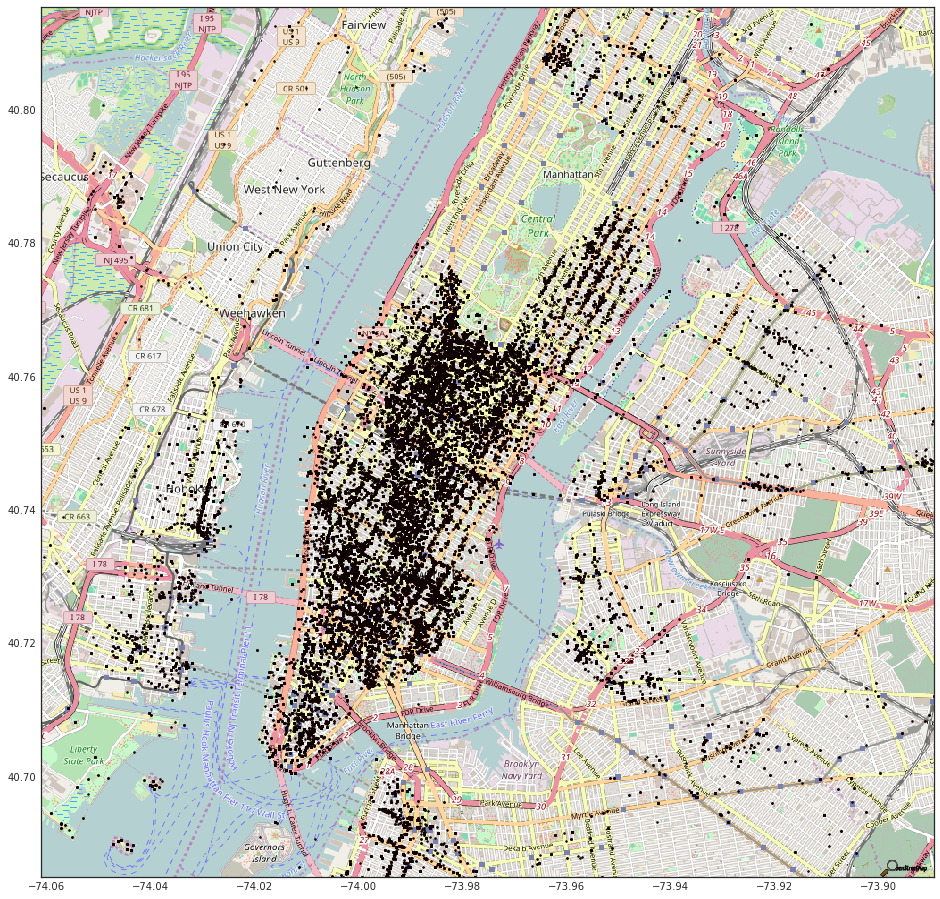

In [7]:
#prepare the figure
plt.style.use('seaborn-white')

fig = plt.figure()
geomap(df[['lon','lat']])

plt.show()

### Machine Learning: k-means clustering

In [8]:
from sklearn.cluster import KMeans

from sklearn import metrics
from sklearn.metrics import pairwise_distances

#### Cluster events
Clustering in 2D, using events' lat and lon as variables.   
200 clusters calculated on a 10% sample of the original set.

In [9]:
ml = KMeans(n_clusters=200, init='k-means++')
ml.fit(df[['lon','lat']].sample(frac=0.1))

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=200, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [10]:
clusters = ml.cluster_centers_
clusters[:10]

array([[-73.99120335,  40.66391779],
       [-73.98290937,  40.75386237],
       [-73.79335576,  40.71874631],
       [-74.15203948,  40.70669825],
       [-73.93601765,  40.85463563],
       [-74.00279916,  40.72088872],
       [-73.84660254,  40.75318819],
       [-73.78373828,  40.64366464],
       [-74.10961753,  40.90204121],
       [-73.94713254,  40.71425609]])

#### Apply clustering
Add cluster id to each event. Now we can group by cluster id.

In [11]:
df['cluster'] = ml.predict(df[['lon','lat']])
df[['uid','lat','lon','vid','name', 'cluster']].sample(10)

uid        lat        lon      vid                    name  cluster
105364    4850  40.672819 -73.976419  1213959             Joe's Pizza       76
33851   114124  40.715492 -73.998146    85428           Nice Green Bo       81
27877   178164  40.759927 -73.985516    64021     Walter Kerr Theatre      130
14905   118439  40.573285 -73.979748   573833  Coney Island Boardwalk       25
55347    77530  40.680988 -73.994135   856498      Gowanus Yacht Club      198
74590    39975  40.755100 -73.993195    37437                    R/GA      186
8632     17720  40.756880 -73.986225    11844            Times Square      130
34688   127998  40.810424 -74.166259   912271   Major League Auto Spa       14
111678    3225  40.745996 -73.986615   729213         pie advertising      147
71171    11991  40.594962 -73.981745   265870     L&B Spumoni Gardens      135

#### Voronoi maps
Visualize the clusters using a voronoi map overlay on the previous picture

In [12]:
from scipy.spatial import Voronoi

# credits to Pauli Virtanen
# https://gist.github.com/pv/8036995

def voronoi_finite_polygons_2d(vor, radius=None):
    """
    Reconstruct infinite voronoi regions in a 2D diagram to finite
    regions.

    Parameters
    ----------
    vor : Voronoi
        Input diagram
    radius : float, optional
        Distance to 'points at infinity'.

    Returns
    -------
    regions : list of tuples
        Indices of vertices in each revised Voronoi regions.
    vertices : list of tuples
        Coordinates for revised Voronoi vertices. Same as coordinates
        of input vertices, with 'points at infinity' appended to the
        end.

    """

    if vor.points.shape[1] != 2:
        raise ValueError("Requires 2D input")

    new_regions = []
    new_vertices = vor.vertices.tolist()

    center = vor.points.mean(axis=0)
    if radius is None:
        radius = vor.points.ptp().max()*2

    # Construct a map containing all ridges for a given point
    all_ridges = {}
    for (p1, p2), (v1, v2) in zip(vor.ridge_points, vor.ridge_vertices):
        all_ridges.setdefault(p1, []).append((p2, v1, v2))
        all_ridges.setdefault(p2, []).append((p1, v1, v2))

    # Reconstruct infinite regions
    for p1, region in enumerate(vor.point_region):
        vertices = vor.regions[region]

        if all([v >= 0 for v in vertices]):
            # finite region
            new_regions.append(vertices)
            continue

        # reconstruct a non-finite region
        ridges = all_ridges[p1]
        new_region = [v for v in vertices if v >= 0]

        for p2, v1, v2 in ridges:
            if v2 < 0:
                v1, v2 = v2, v1
            if v1 >= 0:
                # finite ridge: already in the region
                continue

            # Compute the missing endpoint of an infinite ridge

            t = vor.points[p2] - vor.points[p1] # tangent
            t /= np.linalg.norm(t)
            n = np.array([-t[1], t[0]])  # normal

            midpoint = vor.points[[p1, p2]].mean(axis=0)
            direction = np.sign(np.dot(midpoint - center, n)) * n
            far_point = vor.vertices[v2] + direction * radius

            new_region.append(len(new_vertices))
            new_vertices.append(far_point.tolist())

        # sort region counterclockwise
        vs = np.asarray([new_vertices[v] for v in new_region])
        c = vs.mean(axis=0)
        angles = np.arctan2(vs[:,1] - c[1], vs[:,0] - c[0])
        new_region = np.array(new_region)[np.argsort(angles)]

        # finish
        new_regions.append(new_region.tolist())

    return new_regions, np.asarray(new_vertices)

#### Voronoi maps
This image consists of 4 layers, from botton to top:
 - the openstreet map
 - geo-located events (red dots)
 - the voronoi cells (edges are points equi-distant from centroids)
 - voronoi cells' centroids (k-means cluster centers)

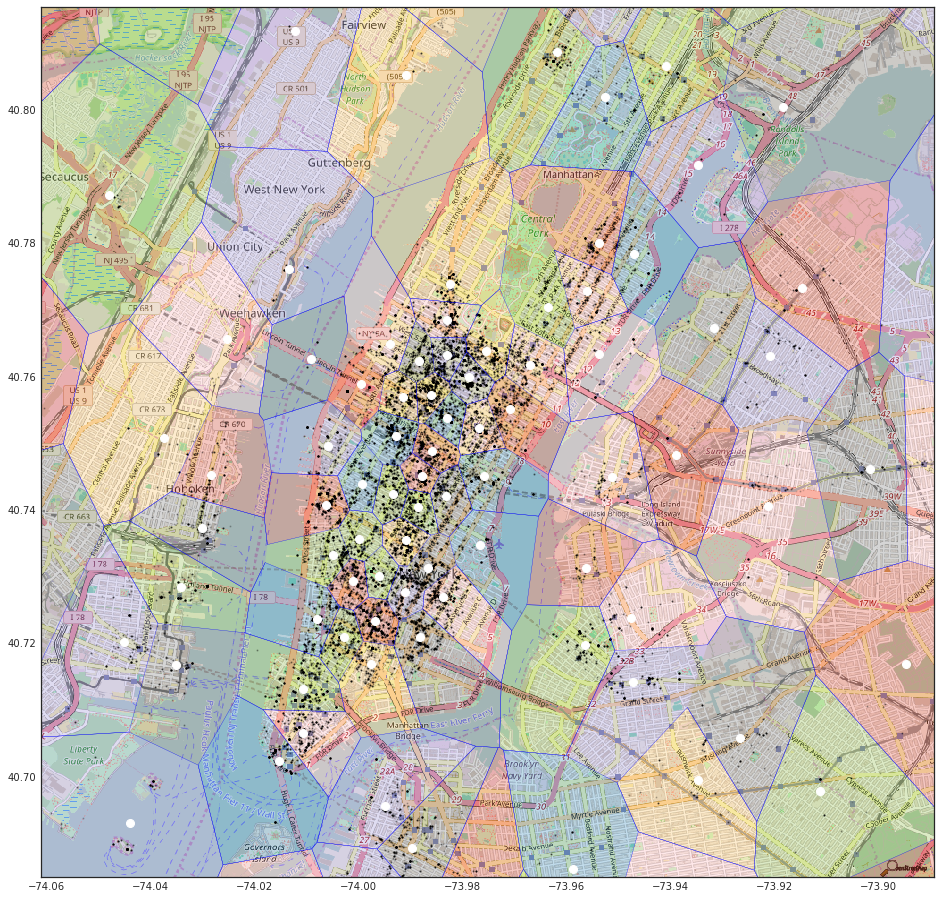

In [17]:
#points = np.array([[c[1], c[0]] for c in clusters])
points = clusters

# compute Voronoi tesselation
vor = Voronoi(points)

# compute regions
regions, vertices = voronoi_finite_polygons_2d(vor)

# prepare figure
plt.style.use('seaborn-white')
fig = plt.figure()

#geomap
geomap(df[['lon','lat']], 13, 2,'k',0.1)

# colorize
for region in regions:
    polygon = vertices[region]
    plt.fill(*zip(*polygon), alpha=0.3)
    plt.plot(*zip(*polygon), c="b", linewidth=0.3)

# centroids
plt.plot(points[:,0], points[:,1], 'wo',markersize=8)

# render
plt.show()

#### Explore venues in each k-mean cluster

In [18]:
gdf = df.groupby(['cluster', 'vid']).size().reset_index()
gdf.columns = ['cluster', 'vid', 'count']

idx = gdf.groupby(['cluster'])['count'].transform(max) == gdf['count']
topvenues_df = gdf[idx].merge(dfv, on='vid', how='inner').sort_values(by='count', ascending=False)

In [19]:
# guarantee one single venue per cluster
topvenues_df = topvenues_df.groupby('cluster').first()

In [20]:
topvenues_df.reset_index(level=0, inplace=True)
topvenues_df.shape

(200, 6)

In [21]:
#top 10 out of 200 clusters by events count
d = topvenues_df[:10].copy()
d

cluster     vid  count        lat        lon  \
0        0  212706     38  40.662908 -73.991674   
1        1   11834    364  40.753816 -73.983618   
2        2  159473     12  40.722022 -73.794222   
3        3  338320     11  40.700972 -74.154786   
4        4   32590     30  40.864813 -73.931917   
5        5   47419     74  40.718880 -74.002494   
6        6   11711    156  40.756425 -73.845420   
7        7   23261   1653  40.643885 -73.782806   
8        8  347669     10  40.902458 -74.104576   
9        9  314970     55  40.714800 -73.944067   

                                name  
0                         Roots Cafe  
1                        Bryant Park  
2              St. John's University  
3     New Jersey Turnpike (near EWR)  
4                      The Cloisters  
5                   Starbucks Coffee  
6                         Citi Field  
7  JFK John F. Kennedy International  
8            Strive Health & Fitness  
9                    The Bagel Store

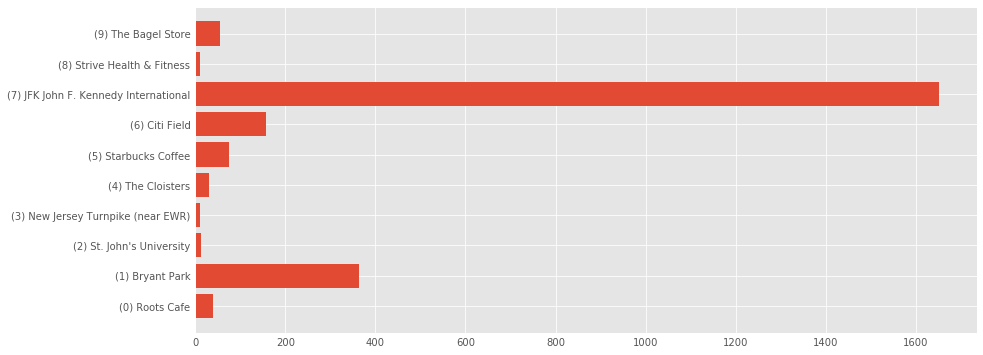

In [28]:
# prepare figure
plt.style.use('ggplot')
fig = plt.figure()
fig.set_size_inches(14,6)

# prefix name with cluster number
d['label'] = d[['cluster', 'name']].apply(lambda x: '({}) {}'.format(int(x[0]), x[1]),axis=1)
plt.barh( range(len(d)), d['count'], align='center')
plt.yticks(range(len(d)),d['label'], fontsize=10)
plt.show()

#### Model Top Venues in Cassandra

In [29]:
session.execute("DROP TABLE IF EXISTS lbsn.kmeans_topvenues");

cql_stmt = """
    CREATE TABLE lbsn.kmeans_topvenues (
      cid    int,
      name   text,
      lat    double,
      lon    double,
      count  bigint,
      url    text,
      PRIMARY KEY (cid)
    );
"""
result = session.execute(cql_stmt)

Store the centroids in cassandra.
We can use a function and apply this row-wise to scan the panda DataFrame

In [30]:
topvenues_df.shape

(200, 6)

In [31]:
#clear the table before inserting data from file
result = session.execute("TRUNCATE lbsn.kmeans_topvenues;")

def insert(x):
    x[1] = x[1].replace("'", "''")
    cql_stmt = """ 
            INSERT INTO lbsn.kmeans_topvenues (cid, name, lat, lon, count) 
                values ({}, '{}', {}, {}, {})""".format(*x)
    
    #print(cql_stmt)
    query = SimpleStatement (cql_stmt,consistency_level=ConsistencyLevel.ONE)
    session.execute(query)

result = topvenues_df[['cluster', 'name', 'lat', 'lon', 'count']].apply(insert,axis=1)

In [32]:
cql_stmt = """
    SELECT * from lbsn.kmeans_topvenues limit 5;
"""
rows = session.execute(cql_stmt)
df = pd.DataFrame(list(rows))
df

cid  count        lat        lon                           name   url
0   23     54  40.582335 -74.165485     Apple Store, Staten Island  None
1  114      9  40.838196 -73.859801             Metropolitan Oval   None
2   53     64  40.834268 -73.946990               625 W 156 Street  None
3  110     41  40.699593 -73.911145  Myrtle—Wycoff Avenues Station  None
4   91     51  40.743823 -74.179538                   Redwood Hall  None

### Storing the k-means model in Cassandra

In [33]:
session.execute("DROP TABLE IF EXISTS lbsn.models");

cql_stmt = """
    CREATE TABLE lbsn.models (
      mid    text,
      model  blob,
      PRIMARY KEY (mid)
    );
"""
result = session.execute(cql_stmt)

Use pickle and binascii to save the model as a cassandra blob

In [34]:
import pickle
import binascii

s = pickle.dumps(ml)
s = binascii.hexlify(s).decode('utf-8')

cql_stmt = "INSERT INTO lbsn.models (mid, model) values ('{}', 0x{});".format('kmeans', s)
    
query  = SimpleStatement (cql_stmt,consistency_level=ConsistencyLevel.ONE)
result = session.execute(query)

Get the model back and test it  with:  
`lon:-73.983618, lat:40.753816 Bryant Park`

In [35]:
cql_stmt = "SELECT model from lbsn.models where mid='kmeans'"
rows = session.execute(cql_stmt)
ml_reloaded = pickle.loads(rows[0].model)

In [36]:
location = np.array([-73.983618, 40.753816]).reshape(1, -1)
cluster_id = ml_reloaded.predict(location)[0]

In [37]:
topvenues_df[topvenues_df.cluster==cluster_id]

cluster    vid  count        lat        lon         name
1        1  11834    364  40.753816 -73.983618  Bryant Park

In [38]:
ml_reloaded.predict(location)[0] == ml.predict(location)[0]

True